# Somerville Open Data Exploration
The city of Somerville has several open datasets that can be downloaded and analyzed.
Of interest, they perform a biannual (every 2 year) survey of resident happiness along with demographic data.
In addition, they have data regarding crime, crashes, and the number of pedestrians/cyclists observed.
I will use this notebook to explore these datasets. I would like to do at least some of the following:
* Explore the datasets for any interesting trends
* Create regression models that can reveal what factors are major contributors to happiness scores
* Cluster residents into different groups to identify what could enhance their living experience

In [1]:
# imports
import pandas as pd
import numpy as np
import scipy
import sklearn
import os
import matplotlib.pyplot as plt

In [2]:
# Loading in data
path2csv = 'C:/Users/kevjm/Documents/GitHub/SomervilleOpenDataExploration/data'
d = os.listdir(path2csv)

df_bike_ped_counts = pd.read_csv(path2csv + '/' + d[0])
df_crashes = pd.read_csv(path2csv + '/' + d[1])
df_crime = pd.read_csv(path2csv + '/' + d[2])
df_happiness = pd.read_csv(path2csv + '/' + d[3],low_memory=False)

The Somerville Happiness dataset (https://data.somervillema.gov/Health-Wellbeing/Somerville-Happiness-Survey-Responses/pfjr-vzaw/about_data) is a large dataframe where each row is a survey respondent. The respondent was asked a number of demographic and lifestyle questions and was also asked to rank their happiness on a scale of 1 - 5. A full description of the data can be found on the Somerville webiste and here is a small sampling of what we are working with.

In [3]:
df_happiness.head()

,ID,Year,Survey.Method,Survey.Language,Gender,Age,Age.mid,Race.Ethnicity,Housing.Status,Tenure,...,Green.Line.Extension.Satisfaction.5pt.num,Green.Line.Extension.Satisfaction.5pt.label,Bus.Bicycle.Lanes.Satisfaction.5pt.num,Bus.Bicycle.Lanes.Satisfaction.5pt.label,Bluebikes.Satisfaction.5pt.num,Bluebikes.Satisfaction.5pt.label,ACS.Year,ACS.Somerville.Median.Income,ACS.Somerville.Avg.Household.Size,Inflation.Adjustment
0,560,2011,Paper,NaN,Man,61 or older,61.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
1,561,2011,Paper,NaN,Woman,26-30,28.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
2,562,2011,Paper,NaN,Man,61 or older,61.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
3,563,2011,Paper,NaN,Woman,61 or older,61.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
4,564,2011,Paper,NaN,Man,26-30,28.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35


## Happiness Survey Exploration

#### Happiness Score by Demographics
There are many ways to divide these data, so I'd like to make a function that plots the distribution of happiness scores as a function of some other feature (e.g., year, age range, ward, etc.)

In [4]:
def plot_happiness_dist(df,groupby_var):
    """
    This function takes the dataframe that houses all happiness survey answers and 
    creates stacked bar plots based on the provided groupby_var.
    
    If one variable is provided, each stack of bar represent the proportion of 
    respondents who scored their happiness as 1, 2, 3, 4, or 5 for that given 
    variable.
    
    If, however, two variables are provided (e.g., [Ward, Year]), then a series of 
    subplots are made for all of the options for the first variable and then split 
    by the second wihtin stacked bars
    """
    my_colors = ['#b0b0b0','#758a9b','#ffd366','#f6a437','#ec7014']
    grouped_scores = (df.groupby(groupby_var)
                      ['Happiness.5pt.num']
                      .value_counts()
                     )
    
    if len(groupby_var) > 2:
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(1,1,1)
        grouped_scores_norm = (grouped_scores.unstack()
                               .iloc[:,0:5]
                               .div(grouped_scores
                                    .unstack()
                                    .sum(axis=1),
                                    axis = 0)
                              )
        grouped_scores_norm.plot(ax = ax,
                                 kind = 'bar',
                                 stacked = True,
                                 color = my_colors,
                                 legend = False)
        ax.set_xlabel(f'{groupby_var}')
        ax.set_ylabel('Prop Respondents')
        ax.set_title(f'Happiness Score Across {groupby_var}')
    else:
        lvl1_vals = sorted(list(set(grouped_scores.index.get_level_values(0))))
        fig,axes = plt.subplots(1,len(lvl1_vals))
        c = 0
        for val in lvl1_vals:
            grouped_scores_sub = grouped_scores.xs(val)
            grouped_scores_sub_norm = (grouped_scores_sub.unstack()
                                       .iloc[:,0:5]
                                       .div(grouped_scores_sub
                                            .unstack()
                                            .sum(axis=1),
                                            axis = 0)
                                      )
            
            # plt.subplot(1,len(lvl1_vals),c+1)
            grouped_scores_sub_norm.plot(ax = axes[c], 
                                         kind = 'bar',
                                         stacked = True, 
                                         color = my_colors,
                                         legend = False)
            axes[c].set_xlabel(groupby_var[1])
            if c == 0:
                axes[c].set_ylabel('Prop Respondents')

            axes[c].set_title(f'{groupby_var[0]}: {val}')
            c += 1
        fig.set_figwidth(20)
    
    plt.show()

The function above will produce stacked bar plots that show the proportion of respondents that scored their happiness on a 1 - 5 scale (5 is best). If we pass one factor (e.g., year) we can see how the distribution of happiness scores changes across time. In the figures below, gray indicates the proportion of respondents who answered 1 and dark orange represents the proportion of respondents who answered 5.

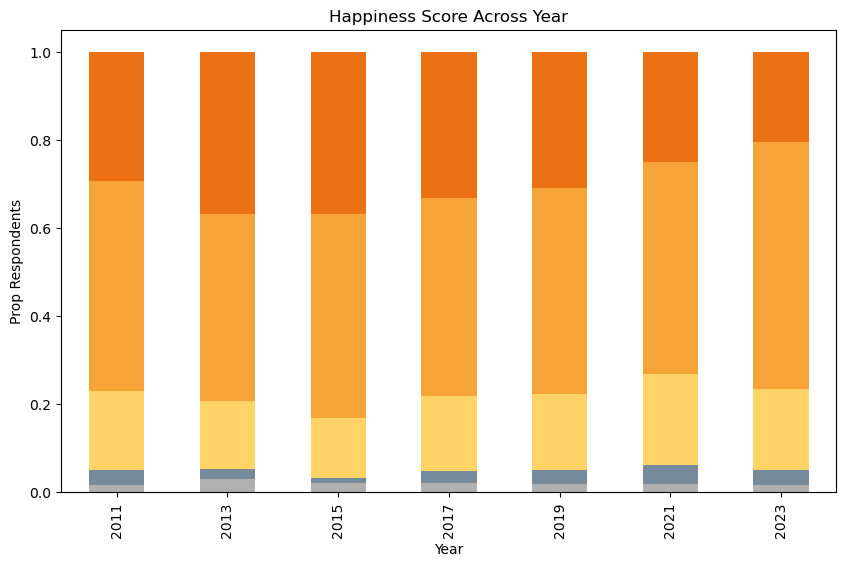

In [5]:
plot_happiness_dist(df_happiness,'Year')

Grouping over year may lose some nuance or subtleties in the data. Thus, the code above can take up to two factors to see how they interact. For instance, we can address whether happiness scores change across time uniformly throughout Somerville. Somerville is divided into 7 representational wards. Below we can pass a list of column names to look at how 

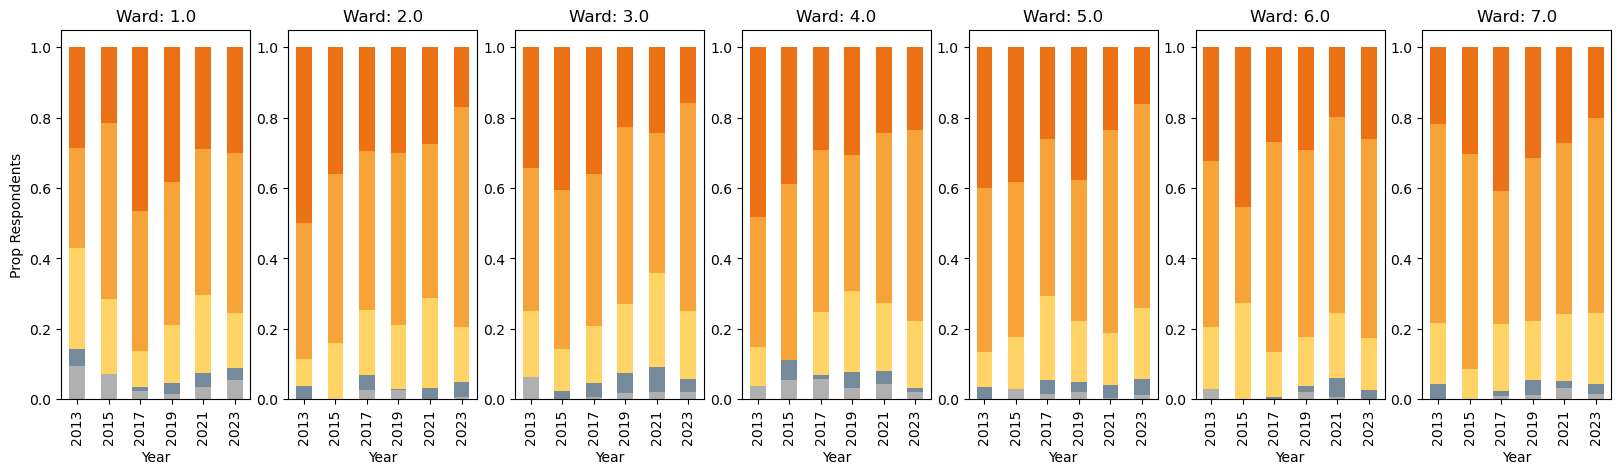

In [6]:
plot_happiness_dist(df_happiness,['Ward','Year'])

Looking at these plots one at a time shows that the majority of respondents score their happiness as 4 or 5 across all years and across all wards. Of particular note, Ward 7 residents in 2015 were very happy! To better understand how local trends influence happiness scores, we can incorporate additional data that is not covered in the survey.

#### Finding Relationships between Survey Factors
There are many questions within the survey each of which may correlate with a happiness score. First, let's define a function that plots a given factor against the average happiness score for each value within the requested factor.

In [7]:
def plot_mn_happiness(df,col_feature,col_score = 'Happiness.5pt.num',sem_flag = False):
    df_grp = (df[[col_feature,col_score]]
          .groupby([col_feature])
          .agg(['mean','median','std','count'])
          .reset_index()
         )
    fig, ax = plt.subplots()
    
    if sem_flag:
        plt.errorbar(df_grp[col_feature],df_grp[col_score,'mean'],
             df_grp[col_score,'std'] / (df_grp[col_score,'count'])**0.5,
             color = 'k')
    else:
        plt.errorbar(df_grp[col_feature],df_grp[col_score,'mean'],
             df_grp[col_score,'std'],
             color = 'k')

    ax.set_ylim(0,5.5)
    ax.set_xlabel(col_feature)

    if col_score == 'Happiness.5pt.num':
        ax.set_ylabel('Mean Happiness Score')
    else:
        ax.set_ylabel(f'Mean ({col_score})')
    

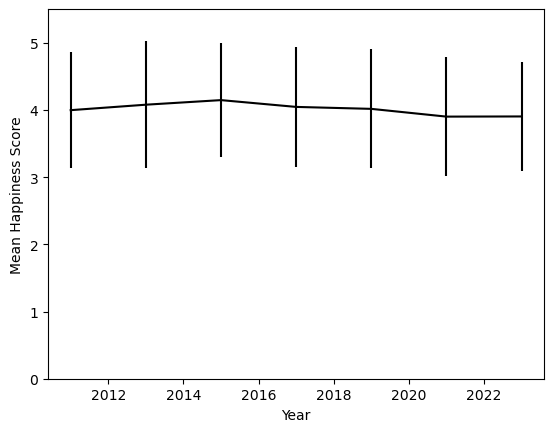

In [8]:
plot_mn_happiness(df_happiness,'Year')

This function is good to look at survey responses one-at-a-time, but I would like to have a higher throughput data visualization. Additionally, while this survey has a lot of information, there are some more data we can add. First, I will add more data to the existing survey data and then iterate across a range of factors to visualize which seem to be related to average happiness scores.

### Incorporating Other Data into Happiness Survey

#### Crime and Crashes
The Somerville Police Department maintains a listing of reported crimes and crashes. We can use these numbers to identify whether the prevalence of either (or both) influence's a resident's happiness in that year.
For now, let's use total number of offenses and crashes as a feature for the happiness survey.

In [9]:
df_crime.head()

,Incident Number,Day and Month Reported,Year Reported,Police Shift,Offense Code,Offense Type,Offense Definition,Offense Sub-Category,Offense Category,Block Code,Ward
0,17000797,1/5,2017,Day Shift (8AM - 4PM),23H,All Other Larceny,All thefts which do not fit any of the Larceny...,Larceny/Theft Offenses,Crimes against Property,2.501735e+14,6
1,17002574,1/13,2017,Day Shift (8AM - 4PM),23F,Theft From Motor Vehicle,The unlawful taking of articles from a motor v...,Theft From Motor Vehicle,Crimes against Property,2.501735e+14,5
2,17002066,1/11,2017,Day Shift (8AM - 4PM),90C,Disorderly Conduct,Any behavior that tends to disturb the public ...,Disorderly Conduct,Other,2.501735e+14,NaN
3,17033676,6/6,2017,Day Shift (8AM - 4PM),90J,Trespass Of Real Property,"To unlawfully enter land, a dwelling, or other...",Trespass Of Real Property,Other,2.501735e+14,1
4,17033690,6/6,2017,First Half (4PM - Midnight),35A,Drug/Narcotic Violations,"The unlawful cultivation, manufacture, distrib...",Drug/Narcotics Offenses,Crimes against Society,2.501735e+14,1


In [10]:
crime_count_yr = (df_crime
                  .groupby('Year Reported').size()
                  .to_frame(name='CrimeCount'))
crime_count_yr

,CrimeCount
Year Reported,
2017,2369
2018,2294
2019,2263
2020,2108
2021,1970
2022,2338
2023,2608
2024,2968
2025,1103


In [11]:
df_crashes.head()

,Crash Number,Date and Time of Crash,Police Shift,Crash Location,Light Conditions,Weather Conditions,Road Surface,Road Contributing Circumstances,Traffic Control Device Type,Roadway Intersection Type,...,Cyclist Involvement (Non-Motorist),Other Non-Motorist Involvement,Non-Motorist Location,Non-Motorist Action,Non-Motorist Condition,Hit and Run Flag,Latitude,Longitude,Ward,Block Code
0,19055217,2019-09-25 13:33:00,Day Shift (8AM - 4PM),"616 BROADWAY Somerville, MA",DAYLIGHT ...,CLEAR ...,DRY ...,NONE ...,NO CONTROLS ...,NOT AT INTERSECTION ...,...,0,0,NaN,NaN,NaN,Y,42.3987,-71.1094,5.0,250173503003004
1,21048200,2021-09-14 16:30:00,First Half (4PM - Midnight),"133 MIDDLESEX AVE Somerville, MA",DAYLIGHT ...,CLEAR ...,DRY ...,NONE ...,NO CONTROLS ...,NOT AT INTERSECTION ...,...,0,0,NaN,NaN,NaN,N,42.3947,-71.0828,1.0,250173501061014
2,18049006,2018-08-17 10:41:00,Day Shift (8AM - 4PM),"40 COLLEGE AV Somerville, MA",DAYLIGHT ...,NaN,DRY ...,NONE ...,FLASHING TRAFIC CONTROL SIGNAL ...,NOT AT INTERSECTION ...,...,0,0,NaN,NaN,NaN,N,42.3981,-71.1217,6.0,250173505001006
3,21006477,2021-02-04 09:42:00,Day Shift (8AM - 4PM),"135 WALNUT ST Somerville, MA",DAYLIGHT ...,CLEAR ...,DRY ...,NONE ...,NO CONTROLS ...,NOT AT INTERSECTION ...,...,0,0,NaN,NaN,NaN,N,42.3884,-71.0922,4.0,250173502011008
4,23054327,2023-09-21 13:30:00,Day Shift (8AM - 4PM),"BROADWAY & IRVING ST Somerville, MA",DAYLIGHT ...,CLEAR ...,DRY ...,NONE ...,NO CONTROLS ...,T-INTERSECTION ...,...,0,0,NaN,NaN,NaN,N,42.4013,-71.1214,6.0,250173506004005


In [12]:
# creating new Year column for crash database from Date and TIme of Crash column
df_crashes['Year'] = (pd.to_datetime(df_crashes['Date and Time of Crash'], format = 'mixed')
                      .dt.year)

In [13]:
crash_count_yr = (df_crashes
                  .groupby('Year').size()
                 .to_frame(name='CrashCount'))

In [14]:
# combine crash and crime counts
crash_crime_counts = pd.merge(crash_count_yr,crime_count_yr,
                           how='outer',
                           left_index = True, right_index = True)
crash_crime_counts

,CrashCount,CrimeCount
2017,NaN,2369
2018,372.0,2294
2019,523.0,2263
2020,369.0,2108
2021,393.0,1970
2022,403.0,2338
2023,389.0,2608
2024,395.0,2968
2025,155.0,1103


In [15]:
# joining counts to df_happiness on the year value
df_happiness_merge = (
    pd.merge(
        df_happiness,crash_crime_counts,
        how = 'left',left_on = 'Year', 
        right_index = True
    )
)

In [16]:
df_happiness_merge.tail()

,ID,Year,Survey.Method,Survey.Language,Gender,Age,Age.mid,Race.Ethnicity,Housing.Status,Tenure,...,Bus.Bicycle.Lanes.Satisfaction.5pt.num,Bus.Bicycle.Lanes.Satisfaction.5pt.label,Bluebikes.Satisfaction.5pt.num,Bluebikes.Satisfaction.5pt.label,ACS.Year,ACS.Somerville.Median.Income,ACS.Somerville.Avg.Household.Size,Inflation.Adjustment,CrashCount,CrimeCount
11186,11780,2023,Online,English,Woman,35-44,39.5,White,Rent,11-15 years,...,4.0,Satisfied,4.0,Satisfied,2022,124110,2.14,1.0,389.0,2608.0
11187,11781,2023,Online,English,Man,35-44,39.5,White,Own,11-15 years,...,5.0,Very Satisfied,NaN,Not Sure,2022,124110,2.14,1.0,389.0,2608.0
11188,11782,2023,Online,English,Man,25-34,29.5,White,Rent,4-7 years,...,4.0,Satisfied,5.0,Very Satisfied,2022,124110,2.14,1.0,389.0,2608.0
11189,11783,2023,Online,English,Woman,45-54,49.5,White,Rent,11-15 years,...,5.0,Very Satisfied,NaN,Not Sure,2022,124110,2.14,1.0,389.0,2608.0
11190,11784,2023,Online,English,Woman,25-34,29.5,Hispanic or Latino,Rent,8-10 years,...,4.0,Satisfied,5.0,Very Satisfied,2022,124110,2.14,1.0,389.0,2608.0


As crime and crashes are not uniformly distributed across the city, I would like to also include a column in the happiness dataframe that gives the total number of crashes or reported crimes per Ward.

In [17]:
crime_count_yr_ward = (df_crime.
                       groupby(['Ward','Year Reported']).size()
                       .to_frame(name='CrimeCount_PerYearPerWard')
                       .reset_index()
                      )
crash_count_yr_ward = (df_crashes.
                       groupby(['Ward','Year']).size()
                       .to_frame(name='CrashCount_PerYearPerWard')
                       .reset_index()
                      )

# prepping crime data to get wards as floats for future joining:
crime_count_yr_ward['Ward'] = crime_count_yr_ward['Ward'].str.get(0) #currently a string starting with the number and followed by white space
crime_count_yr_ward = crime_count_yr_ward.loc[crime_count_yr_ward['Ward']!='C',:] #a C appeared in the Ward designation
crime_count_yr_ward['Ward'] = crime_count_yr_ward['Ward'].astype(float) #changing to float for future merges

# prepping crash data for future merges
crash_count_yr_ward['Year'] = crash_count_yr_ward['Year'].astype('int64')

In [18]:
print(crime_count_yr_ward.info())
crime_count_yr_ward.head(15)

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 0 to 62
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ward                       63 non-null     float64
 1   Year Reported              63 non-null     int64  
 2   CrimeCount_PerYearPerWard  63 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 2.0 KB
None


,Ward,Year Reported,CrimeCount_PerYearPerWard
0,1.0,2017,699
1,1.0,2018,623
2,1.0,2019,598
3,1.0,2020,466
4,1.0,2021,503
5,1.0,2022,579
6,1.0,2023,631
7,1.0,2024,873
8,1.0,2025,365
9,2.0,2017,405


In [19]:
print(crash_count_yr_ward.info())
crash_count_yr_ward.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ward                       56 non-null     float64
 1   Year                       56 non-null     int64  
 2   CrashCount_PerYearPerWard  56 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 1.4 KB
None


,Ward,Year,CrashCount_PerYearPerWard
0,1.0,2018,59
1,1.0,2019,76
2,1.0,2020,62
3,1.0,2021,55
4,1.0,2022,85
5,1.0,2023,78
6,1.0,2024,74
7,1.0,2025,35
8,2.0,2018,75
9,2.0,2019,89


In [20]:
# merge crash and crime statistics into single dataframe
crash_crime_yr_ward = (pd
                       .merge(crash_count_yr_ward,crime_count_yr_ward,
                              how = 'right',
                              right_on = ['Ward','Year Reported'],
                              left_on = ['Ward','Year'])
                       .drop('Year',axis=1)
)
crash_crime_yr_ward.head(15)

,Ward,CrashCount_PerYearPerWard,Year Reported,CrimeCount_PerYearPerWard
0,1.0,NaN,2017,699
1,1.0,59.0,2018,623
2,1.0,76.0,2019,598
3,1.0,62.0,2020,466
4,1.0,55.0,2021,503
5,1.0,85.0,2022,579
6,1.0,78.0,2023,631
7,1.0,74.0,2024,873
8,1.0,35.0,2025,365
9,2.0,NaN,2017,405


In [21]:
crash_crime_yr_ward.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ward                       63 non-null     float64
 1   CrashCount_PerYearPerWard  56 non-null     float64
 2   Year Reported              63 non-null     int64  
 3   CrimeCount_PerYearPerWard  63 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 2.1 KB


In [22]:
df_happiness_merge.tail(15)

,ID,Year,Survey.Method,Survey.Language,Gender,Age,Age.mid,Race.Ethnicity,Housing.Status,Tenure,...,Bus.Bicycle.Lanes.Satisfaction.5pt.num,Bus.Bicycle.Lanes.Satisfaction.5pt.label,Bluebikes.Satisfaction.5pt.num,Bluebikes.Satisfaction.5pt.label,ACS.Year,ACS.Somerville.Median.Income,ACS.Somerville.Avg.Household.Size,Inflation.Adjustment,CrashCount,CrimeCount
11176,11770,2023,Online,English,Man,65-74,69.5,White,Own,21 years or more,...,2.0,Unsatisfied,NaN,Not Sure,2022,124110,2.14,1.0,389.0,2608.0
11177,11771,2023,Online,English,Woman,35-44,39.5,White,Rent,1-3 years,...,5.0,Very Satisfied,4.0,Satisfied,2022,124110,2.14,1.0,389.0,2608.0
11178,11772,2023,Online,English,Woman,45-54,49.5,White,Own,1-3 years,...,1.0,Very Unsatisfied,NaN,NaN,2022,124110,2.14,1.0,389.0,2608.0
11179,11773,2023,Online,English,Man,45-54,49.5,White,Own,21 years or more,...,4.0,Satisfied,4.0,Satisfied,2022,124110,2.14,1.0,389.0,2608.0
11180,11774,2023,Online,English,Woman,55-64,59.5,White,Own,8-10 years,...,2.0,Unsatisfied,NaN,Not Sure,2022,124110,2.14,1.0,389.0,2608.0
11181,11775,2023,Online,English,Prefer not to answer,17 or younger,17.0,Prefer not to answer,Prefer not to answer,1-3 years,...,4.0,Satisfied,3.0,Neutral,2022,124110,2.14,1.0,389.0,2608.0
11182,11776,2023,Online,English,Woman,25-34,29.5,Black or African American,Rent,1-3 years,...,4.0,Satisfied,4.0,Satisfied,2022,124110,2.14,1.0,389.0,2608.0
11183,11777,2023,Online,English,Man,65-74,69.5,White,Own,21 years or more,...,4.0,Satisfied,3.0,Neutral,2022,124110,2.14,1.0,389.0,2608.0
11184,11778,2023,Online,English,Woman,35-44,39.5,White,Own,1-3 years,...,3.0,Neutral,2.0,Unsatisfied,2022,124110,2.14,1.0,389.0,2608.0
11185,11779,2023,Online,English,Man,25-34,29.5,White,Rent,1-3 years,...,3.0,Neutral,5.0,Very Satisfied,2022,124110,2.14,1.0,389.0,2608.0


In [23]:
# combine the crash and crime statistics per ward with the survey statistics by merging across multiple columns
df_happiness_merge = (pd
                     .merge(df_happiness_merge,crash_crime_yr_ward,
                           how = 'left',
                           left_on = ['Year','Ward'],
                           right_on = ['Year Reported','Ward'])
                      .drop('Year Reported',axis=1)
                     )

df_happiness_merge.tail(15)

,ID,Year,Survey.Method,Survey.Language,Gender,Age,Age.mid,Race.Ethnicity,Housing.Status,Tenure,...,Bluebikes.Satisfaction.5pt.num,Bluebikes.Satisfaction.5pt.label,ACS.Year,ACS.Somerville.Median.Income,ACS.Somerville.Avg.Household.Size,Inflation.Adjustment,CrashCount,CrimeCount,CrashCount_PerYearPerWard,CrimeCount_PerYearPerWard
11176,11770,2023,Online,English,Man,65-74,69.5,White,Own,21 years or more,...,NaN,Not Sure,2022,124110,2.14,1.0,389.0,2608.0,59.0,304.0
11177,11771,2023,Online,English,Woman,35-44,39.5,White,Rent,1-3 years,...,4.0,Satisfied,2022,124110,2.14,1.0,389.0,2608.0,40.0,200.0
11178,11772,2023,Online,English,Woman,45-54,49.5,White,Own,1-3 years,...,NaN,NaN,2022,124110,2.14,1.0,389.0,2608.0,67.0,433.0
11179,11773,2023,Online,English,Man,45-54,49.5,White,Own,21 years or more,...,4.0,Satisfied,2022,124110,2.14,1.0,389.0,2608.0,67.0,433.0
11180,11774,2023,Online,English,Woman,55-64,59.5,White,Own,8-10 years,...,NaN,Not Sure,2022,124110,2.14,1.0,389.0,2608.0,33.0,199.0
11181,11775,2023,Online,English,Prefer not to answer,17 or younger,17.0,Prefer not to answer,Prefer not to answer,1-3 years,...,3.0,Neutral,2022,124110,2.14,1.0,389.0,2608.0,NaN,NaN
11182,11776,2023,Online,English,Woman,25-34,29.5,Black or African American,Rent,1-3 years,...,4.0,Satisfied,2022,124110,2.14,1.0,389.0,2608.0,67.0,433.0
11183,11777,2023,Online,English,Man,65-74,69.5,White,Own,21 years or more,...,3.0,Neutral,2022,124110,2.14,1.0,389.0,2608.0,59.0,304.0
11184,11778,2023,Online,English,Woman,35-44,39.5,White,Own,1-3 years,...,2.0,Unsatisfied,2022,124110,2.14,1.0,389.0,2608.0,33.0,199.0
11185,11779,2023,Online,English,Man,25-34,29.5,White,Rent,1-3 years,...,5.0,Very Satisfied,2022,124110,2.14,1.0,389.0,2608.0,55.0,313.0


#### Pedestrians and Cyclists
As a cyclist, my happiness is definitely related to how easy it is to bike around Somerville and it brings me joy to see other cyclists. Somerville has an ongoing survey where volunteers count the number of pedestrians and cyclists at known locations throughout the city. This survey is performed annually in the morning and evening throughout the city and provides the total number of people on bikes or walking (including those with mobility devices) in a given 30-min window. From these data I will add the average number of cyclists and pedestrians across the locations for each year as features in the happiness survey. In addition, I will engineer a pedestrian-to-cyclist score indicate the prevalence of cyclists throughout the city.

In [24]:
df_bike_ped_counts.head()

,Year,Location #,Location Name,Latitude,Longitude,AM/PM,Mode,Count
0,2024,1,Webster Ave & Prospect St,42.3770,-71.0956,AM,Bike,77
1,2024,1,Webster Ave & Prospect St,42.3770,-71.0956,AM,Ped,204
2,2024,1,Webster Ave & Prospect St,42.3770,-71.0956,PM,Bike,245
3,2024,1,Webster Ave & Prospect St,42.3770,-71.0956,PM,Ped,377
4,2024,2,Washington St & Somerville Ave,42.3796,-71.0964,AM,Bike,214


In [25]:
#group bike and pedestrian counts by year and mode (collapsing across locations and time of day)
df_grouped = (df_bike_ped_counts
              .groupby(['Year','Mode'])
              .agg({'Count': 'mean'})
              .reset_index())

# average the bike and pedestrian counts
mn_count_yr_bike = (df_grouped
                    .loc[df_grouped['Mode']=='Bike',['Year','Count']]
                    .rename(columns={'Count': 'bike_count'})
                   )
mn_count_yr_ped = (df_grouped
                    .loc[df_grouped['Mode']=='Ped',['Year','Count']]
                    .rename(columns={'Count': 'ped_count'})
                   )

# merge both counts into single data frame
mn_count_yr_merge = pd.merge(mn_count_yr_bike,mn_count_yr_ped,
                          on = 'Year',
                          how = 'left'
                         )

# creating ratio metric for pedestrian to cyclists
mn_count_yr_merge['ped2bike_foldinc'] = (
    mn_count_yr_merge['ped_count'].div(mn_count_yr_merge['bike_count'])
)

In [26]:
mn_count_yr_merge.tail()

,Year,bike_count,ped_count,ped2bike_foldinc
10,2020,60.404762,147.821429,2.447182
11,2021,68.226190,189.904762,2.783458
12,2022,118.583333,278.380952,2.347555
13,2023,148.428571,284.797619,1.918752
14,2024,143.988095,282.654762,1.963043


In [27]:
# merging counts and fold increase to happiness table
df_happiness_merge = (
    pd.merge(
        df_happiness_merge,mn_count_yr_merge,
        on = 'Year',
        how = 'left',
    )
)

In [28]:
df_happiness_merge.tail()

,ID,Year,Survey.Method,Survey.Language,Gender,Age,Age.mid,Race.Ethnicity,Housing.Status,Tenure,...,ACS.Somerville.Median.Income,ACS.Somerville.Avg.Household.Size,Inflation.Adjustment,CrashCount,CrimeCount,CrashCount_PerYearPerWard,CrimeCount_PerYearPerWard,bike_count,ped_count,ped2bike_foldinc
11186,11780,2023,Online,English,Woman,35-44,39.5,White,Rent,11-15 years,...,124110,2.14,1.0,389.0,2608.0,59.0,304.0,148.428571,284.797619,1.918752
11187,11781,2023,Online,English,Man,35-44,39.5,White,Own,11-15 years,...,124110,2.14,1.0,389.0,2608.0,33.0,199.0,148.428571,284.797619,1.918752
11188,11782,2023,Online,English,Man,25-34,29.5,White,Rent,4-7 years,...,124110,2.14,1.0,389.0,2608.0,55.0,313.0,148.428571,284.797619,1.918752
11189,11783,2023,Online,English,Woman,45-54,49.5,White,Rent,11-15 years,...,124110,2.14,1.0,389.0,2608.0,40.0,200.0,148.428571,284.797619,1.918752
11190,11784,2023,Online,English,Woman,25-34,29.5,Hispanic or Latino,Rent,8-10 years,...,124110,2.14,1.0,389.0,2608.0,78.0,631.0,148.428571,284.797619,1.918752


### Working Across Features

### Preparing for a Regression Model
Now that we have a sense of how various features influence the average happiness score, I would like to figure out what features are most strongly related to the happiness score. For this, I will turn to a linear regression model. This model assumes that some output (here, a respondent's happiness score) can be predicted by a linear sum of a set of features (here, the survey responses and additional data we added above). To build the model, we must first process the data so that it can be used in the training. Note that we will be creating a model that predicts the 5-point happiness score of a respondent, so let's remove any rows where this answer was not provided.

In [29]:
nan_count = df_happiness_merge['Happiness.5pt.num'].isna().sum()
print(f'There were {nan_count} rows without a Happiness Score')
df_happiness_merge.dropna(subset = ['Happiness.5pt.num'],inplace = True)
print()
nan_count = df_happiness_merge['Happiness.5pt.num'].isna().sum()
print(f'There are now {nan_count} rows without a Happiness Score')

There were 283 rows without a Happiness Score

There are now 0 rows without a Happiness Score


#### Selecting features
The final merged data frame has 136 columns some of which provide redundant information. Note that those columns ending in YN are binary features indicating yes or no.

In [30]:
df_happiness_merge.columns.tolist()

['ID',
 'Year',
 'Survey.Method',
 'Survey.Language',
 'Gender',
 'Age',
 'Age.mid',
 'Race.Ethnicity',
 'Housing.Status',
 'Tenure',
 'Tenure.mid',
 'Tenure.Address',
 'Tenure.Address.mid',
 'Days.In.Person.Commute',
 'Transportation.Bicycle.YN',
 'Transportation.Car.YN',
 'Transportation.Public.Transit.YN',
 'Transportation.Rideshare.YN',
 'Transportation.Walk.YN',
 'Children.YN',
 'Cultural.Religious.Minority.YN',
 'Disability.YN',
 'Immigrant.YN',
 'LGBTQIA.YN',
 'Student.YN',
 'Veteran.YN',
 'Difficulty.Paying.YN',
 'Discrimination.YN',
 'Household.Size',
 'Household.Size.num',
 'Bedrooms',
 'Bedrooms.num',
 'Cars',
 'Cars.num',
 'Household.Income',
 'Household.Income.mid',
 'Income.Per.Number.In.Household',
 'Likely.Low.Income',
 'Rent.Mortgage',
 'Rent.Mortgage.mid',
 'Rent.as.Percent.of.Income',
 'Rent.Mortgage.Per.Bedroom',
 'Likely.Cost.Burdened',
 'Language.Spoken',
 'Ward',
 'Happiness.5pt.num',
 'Happiness.5pt.label',
 'Life.Satisfaction.5pt.num',
 'Life.Satisfaction.5pt.l

Some columns have a 3 or 5 point scale with corresponding labels. However, it appears that in those columns with a three point scale, there are more labels than numbers resuluting in missing data. Here is a function that will print the value_counts of the label and number columns for a given question

In [31]:
def print_num_lbl_counts(col_prefix):
    '''
    This function will print the counts of unique 
    values within the df_happiness_merge dataframe
    for a given column name. This function will
    also print the number of nans within the numerical
    column.
    '''
    col_lbl = col_prefix + '.label'
    col_num = col_prefix + '.num'
    print(df_happiness_merge[col_lbl].value_counts())
    print()
    print(df_happiness_merge[col_num].value_counts())
    nan_count = df_happiness_merge[col_num].isna().sum()
    print()
    print(f'The {col_num} column has {nan_count} nan values')

In [32]:
print_num_lbl_counts('COVID.Resources.Satisfaction.5pt')

COVID.Resources.Satisfaction.5pt.label
Satisfied           285
Very Satisfied      245
Not Sure            188
Neutral             140
Unsatisfied          37
Very Unsatisfied     21
Name: count, dtype: int64

COVID.Resources.Satisfaction.5pt.num
4.0    285
5.0    245
3.0    140
2.0     37
1.0     21
Name: count, dtype: int64

The COVID.Resources.Satisfaction.5pt.num column has 10180 nan values


Based on how this dataset is structured, a nan is given if the respondent selected Not Sure or if an answer was not provided (either because the respondent did not answer or because the question was not present on the survey). For simplicity, let's plan to impute these missing values with most common values (see below), but this is a point we may want to return to if the model has poor predictive power.

For now, let's select only the numerical columns for the regression model:

In [33]:
col_numeric = df_happiness_merge.select_dtypes(include=['float64','int64']).columns.tolist()

In [34]:
col_numeric

['ID',
 'Year',
 'Age.mid',
 'Tenure.mid',
 'Tenure.Address.mid',
 'Transportation.Bicycle.YN',
 'Transportation.Car.YN',
 'Transportation.Public.Transit.YN',
 'Transportation.Rideshare.YN',
 'Transportation.Walk.YN',
 'Children.YN',
 'Cultural.Religious.Minority.YN',
 'Disability.YN',
 'Immigrant.YN',
 'LGBTQIA.YN',
 'Student.YN',
 'Veteran.YN',
 'Difficulty.Paying.YN',
 'Discrimination.YN',
 'Household.Size.num',
 'Bedrooms.num',
 'Cars.num',
 'Household.Income.mid',
 'Income.Per.Number.In.Household',
 'Likely.Low.Income',
 'Rent.Mortgage.mid',
 'Rent.as.Percent.of.Income',
 'Rent.Mortgage.Per.Bedroom',
 'Likely.Cost.Burdened',
 'Ward',
 'Happiness.5pt.num',
 'Life.Satisfaction.5pt.num',
 'Neighborhood.Satisfaction.5pt.num',
 'Somerville.Satisfaction.5pt.num',
 'Beauty.Neighborhood.Satisfaction.5pt.num',
 'Getting.Around.Convenience.Satisfaction.5pt.num',
 'Transportation.Options.Satisfaction.5pt.num',
 'Cleanliness.Neighborhood.Satisfaction.5pt.num',
 'Parks.Proximity.Satisfaction.5

Let's also pull out the columns that are categorical in nature:

In [35]:
col_categorical = df_happiness_merge.select_dtypes(exclude=['float64','int64']).columns.tolist()
col_categorical

['Survey.Method',
 'Survey.Language',
 'Gender',
 'Age',
 'Race.Ethnicity',
 'Housing.Status',
 'Tenure',
 'Tenure.Address',
 'Days.In.Person.Commute',
 'Household.Size',
 'Bedrooms',
 'Cars',
 'Household.Income',
 'Rent.Mortgage',
 'Language.Spoken',
 'Happiness.5pt.label',
 'Life.Satisfaction.5pt.label',
 'Neighborhood.Satisfaction.5pt.label',
 'Somerville.Satisfaction.5pt.label',
 'Beauty.Neighborhood.Satisfaction.5pt.label',
 'Getting.Around.Convenience.Satisfaction.5pt.label',
 'Transportation.Options.Satisfaction.5pt.label',
 'Cleanliness.Neighborhood.Satisfaction.5pt.label',
 'Parks.Proximity.Satisfaction.5pt.label',
 'Grocery.Proximity.Satisfaction.5pt.label',
 'City.Services.Quality.Satisfaction.5pt.label',
 'Housing.Cost.Satisfaction.5pt.label',
 'Housing.Condition.Satisfaction.5pt.label',
 'Streets.Sidewalks.Maintenance.Satisfaction.5pt.label',
 'Sidewalks.Accessibility.Satisfaction.5pt.label',
 'Childcare.Availability.Satisfaction.5pt.label',
 'Neighbors.Relationship.Satisf

As you can see, we have several categorical columns that are repeated numerically in the columns above. Given that we are going to use numerical values for our model, we want to select only those categorical columns that are unique (i.e., not repeated in the numerical list).

In [36]:
col_categorical_unique = []
for s_cat in col_categorical:
    if (
        not any(s_cat in s_num for s_num in col_numeric) 
        and 'label' not in s_cat
       ):
        col_categorical_unique.append(s_cat)

col_categorical_unique

['Survey.Method',
 'Survey.Language',
 'Gender',
 'Race.Ethnicity',
 'Housing.Status',
 'Days.In.Person.Commute',
 'Language.Spoken']

Now that we have the full selection of numerical and categorical columns that will be part of our training set, let's create a dataframe with only these columns.

In [37]:
col_for_mdl = col_numeric + col_categorical_unique
df_happiness_subset = df_happiness_merge.loc[:,col_for_mdl]
df_happiness_subset = df_happiness_subset.drop(['ACS.Year'],axis=1) #removing a redundant numerical column
delta_col = len(df_happiness_merge.columns) - len(df_happiness_subset.columns)
print(f'{delta_col} redundant columns removed from survey dataframe')
print(f'Resultant data frame has {df_happiness_subset.shape[0]} rows and {df_happiness_subset.shape[1]} columns')
df_happiness_subset.tail()

49 redundant columns removed from survey dataframe
Resultant data frame has 10908 rows and 87 columns


,ID,Year,Age.mid,Tenure.mid,Tenure.Address.mid,Transportation.Bicycle.YN,Transportation.Car.YN,Transportation.Public.Transit.YN,Transportation.Rideshare.YN,Transportation.Walk.YN,...,bike_count,ped_count,ped2bike_foldinc,Survey.Method,Survey.Language,Gender,Race.Ethnicity,Housing.Status,Days.In.Person.Commute,Language.Spoken
11186,11780,2023,39.5,13.0,13.0,0.0,1.0,1.0,0.0,1.0,...,148.428571,284.797619,1.918752,Online,English,Woman,White,Rent,1 - 2 days,English only
11187,11781,2023,39.5,13.0,9.0,1.0,1.0,0.0,0.0,0.0,...,148.428571,284.797619,1.918752,Online,English,Man,White,Own,5 or more days,English only
11188,11782,2023,29.5,5.5,0.5,1.0,1.0,1.0,0.0,1.0,...,148.428571,284.797619,1.918752,Online,English,Man,White,Rent,3 - 4 days,English only
11189,11783,2023,49.5,13.0,13.0,0.0,0.0,1.0,1.0,1.0,...,148.428571,284.797619,1.918752,Online,English,Woman,White,Rent,Less than 1 day,English only
11190,11784,2023,29.5,9.0,9.0,0.0,1.0,1.0,0.0,1.0,...,148.428571,284.797619,1.918752,Online,English,Woman,Hispanic or Latino,Rent,3 - 4 days,English+


#### Processing data: Filling in Missing Values
In a few instances, there are no answers for a given question. This could be because the repsondent did not answer or that the question was not included in that year's survey. Nevertheless, we want to fill in the missing value. We can handle this in a few different ways:

1. Remove the rows with missing data.
2. Perform a simple imputation.
3. Perform a more complex imputation.

I'm reticent to throw out data so that leaves us with options 2 and 3. While I like the idea of a complex imputation, let's start simple with filling in missing values with the most common values from the other columns.

However, there are a couple of columns that will be specially handled. First, we'll remove any row without a Happiness score as that is the feature we are trying to predict. Second, we'll replace any missing Ward information with the value of 8 (there are only 7 wards in Somerville).

In [38]:
# Remove rows without Happiness Score
df_happiness_subset = df_happiness_subset.dropna(subset = ['Happiness.5pt.num'])

# Fill missing Ward data with a value of 8
df_happiness_subset['Ward'] = df_happiness_subset['Ward'].fillna(8)

Option 2: Simple Imputations. As a first pass, let's just use either the median or mode to impute values

In [39]:
# to fill the remaining columns with the most common value, I'll create a custom function and apply to the dataframe
def fill_w_mode(series):
    ''' this function will replace all missing values with the series-wide mode.
        Should work with numeric and cateogrical columns
    '''
    return series.fillna(series.mode().values[0])

def fill_w_mdn(series):
    ''' this function will replace all missing values with the series-wide median
    if the series is made up of integers; otherwise returns the mode.
    '''
    if series.dtype == 'int64' or series.dtype == 'int32':
        return series.fillna(series.median())
    else:
        return series.fillna(series.mode().values[0])

In [40]:
df_happiness_filled = df_happiness_subset.apply(fill_w_mode)
# df_happiness_filled = df_happiness_subset.apply(fill_w_mdn)

In [41]:
n_null = df_happiness_filled.isnull().any(axis=1).sum()
n_total = df_happiness_filled.shape[0]
print(f'There are {n_null} rows of {n_total} total rows with missing data.')

There are 0 rows of 10908 total rows with missing data.


#### Processing data: One-Hot Encoding Categorical and Scaling Numerical
Now that we have updated the rows in the dataframe so that there are no missing values, we can pull out the happiness scores from the training set and then perform subsequent preprocessing steps.

In [42]:
y_happiness = df_happiness_filled['Happiness.5pt.num'].to_numpy()
df_happiness_filled = df_happiness_filled.drop(['Happiness.5pt.num'],axis=1)

Several of the survey questions are categorical in nature (e.g., gender, Ward, etc.). For these, I will build a one-hot encoder which will assist in training. In addition, there are a few numerical values (e.g., pedestrian counts) that are on a different scale than the binary values given by one-hot encoding or in the survey results. I'll start with a MinMaxScaler, but could also pursue StandardScaler if the model needs improvement.

To incorporate encoding and scaling efficiently, I'll use a column transformer from scikit-learn.

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

OHE_col = col_categorical_unique + ['Ward','Year']
MMS_col =  ['CrashCount','CrimeCount',
            'CrashCount_PerYearPerWard','CrimeCount_PerYearPerWard',
            'bike_count','ped_count','ped2bike_foldinc']

CT = ColumnTransformer(
    transformers = [
        ('ohe',OneHotEncoder(),OHE_col),
        ('MinMax',MinMaxScaler(),MMS_col)
    ],
    remainder = 'passthrough'
)

X_happiness = CT.fit_transform(df_happiness_filled)

### Training and Evaluating Regression Models
Now that we have a fully preprocessed dataset and a set of values to predict, we can build our regression model. For regularization, we'll use Ridge regression. Let's use standard values and then evaluate the results. Specifically, we'll start with RidgeCV with built-in cross-validation

In [44]:
from sklearn.linear_model import RidgeCV, Ridge
happiness_mdl = Ridge();
happiness_mdl.fit(X_happiness,y_happiness);

# print(f'Model Trained, R^2 = {round(happiness_mdl.score(X_happiness,y_happiness),4)}, best alpha = {happiness_mdl.alpha_}')
print(f'Model Trained, R^2 = {round(happiness_mdl.score(X_happiness,y_happiness),4)}')

Model Trained, R^2 = 0.5295


Without any feature engineering, we have an R^2 value of ~0.53 which can be better. Upon closer inspection, I noticed that certain features (e.g., rent/mortgage) are on different scales that other numeric features. I'll add those to the scaling list when building the pipeline.

To make model optimization a little easier, I'll create a pipeline that will make it easier to change model components:

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer

OHE_col = col_categorical_unique + ['Ward','Year']
MMS_col =  ['CrashCount','CrimeCount',
            'CrashCount_PerYearPerWard','CrimeCount_PerYearPerWard',
            'bike_count','ped_count','ped2bike_foldinc',
            'Income.Per.Number.In.Household','Rent.Mortgage.mid',
            'Rent.Mortgage.Per.Bedroom','ACS.Somerville.Median.Income']

# create column transformer for encoding and scaling
CT = ColumnTransformer(
    transformers = [
        ('ohe',OneHotEncoder(),OHE_col),
        ('MinMax',MinMaxScaler(),MMS_col)
    ],
    remainder = 'passthrough'
)

pipeline = Pipeline([
    ('encode_scale',CT),
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ridge',Ridge(alpha = 0.1))
])

With a pipeline, it should be easier to evaluate different models. Let's start with our original data without feature engineering:

In [55]:
X_happiness = df_happiness_subset.drop(['Happiness.5pt.num'],axis=1)
y_happiness = df_happiness_subset['Happiness.5pt.num']
pipeline.fit(X_happiness,y_happiness);
r2 = round(pipeline.score(X_happiness,y_happiness),4);
print(f'R^2 = {r2}')

R^2 = 0.5299


Another option is to use a different prediction model (e.g., RandomForest). To implement this change, I'll recreate the pipeline:

In [56]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('encode_scale',CT),
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('rf',RandomForestClassifier(n_estimators=100))
])

In [59]:
y_happiness.head()

0    5.0
1    4.0
2    4.0
3    5.0
4    3.0
Name: Happiness.5pt.num, dtype: float64

In [57]:
pipeline_rf.fit(X_happiness,y_happiness);
r2 = round(pipeline_rf.score(X_happiness,y_happiness),4);
print(f'R^2 = {r2}')

R^2 = 1.0


#### Feature Engineering
Let's try to engineer a few features that may help with predictive power. First, the survey data provides an inflation scale for each year. Let's create a function that multiplies all financial questions by that value.

In [47]:
money_ftrs = ['Income.Per.Number.In.Household','Rent.Mortgage.mid',
            'Rent.Mortgage.Per.Bedroom','ACS.Somerville.Median.Income']
money_ftrs_adj = list(map(lambda x: x + '.adj', money_ftrs))

In [48]:
X_happiness[money_ftrs_adj] = (X_happiness[money_ftrs]
                               .multiply(X_happiness['Inflation.Adjustment']
                                         ,axis = 'rows')
                              )
OHE_col = col_categorical_unique + ['Ward','Year']
MMS_col =  ['CrashCount','CrimeCount',
            'CrashCount_PerYearPerWard','CrimeCount_PerYearPerWard',
            'bike_count','ped_count','ped2bike_foldinc',
            'Income.Per.Number.In.Household','Rent.Mortgage.mid',
            'Rent.Mortgage.Per.Bedroom','ACS.Somerville.Median.Income',
            'Income.Per.Number.In.Household.adj','Rent.Mortgage.mid.adj',
            'Rent.Mortgage.Per.Bedroom.adj','ACS.Somerville.Median.Income.adj']

In [49]:
pipeline.fit(X_happiness,y_happiness);
r2 = round(pipeline.score(X_happiness,y_happiness),4);
print(f'R^2 = {r2}')

R^2 = 0.5299


Well, that didn't help much, but future feature engineering may increase the R^2 value! For the time-being, let's pretend this model is useful and determine which features are of greatest importance within the context of predicting happiness in Somerville.

### Feature Importance